<a href="https://colab.research.google.com/github/SEOYUNJE/Lung-Image-Analysis/blob/main/discuss/Embedding%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q opendatasets
import opendatasets as od
import os
import opendatasets as od

od.download('https://www.kaggle.com/datasets/seoyunje/cxr-embedding')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sehyeoncheon
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/seoyunje/cxr-embedding


100%|██████████| 72.5M/72.5M [00:01<00:00, 62.8MB/s]


In [2]:
import gc
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
import pickle

import tensorflow as tf
from tensorflow.keras import *

import tensorflow.keras.backend as K, gc

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score


import warnings
import albumentations as albu
warnings.filterwarnings('ignore')

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

LOAD_EMBEDDINGS_FROM = '/content/cxr-embedding/'

tensorflow version:  2.17.0
Using 0 GPUs


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
df_train = pd.read_csv(f'{LOAD_EMBEDDINGS_FROM}effnet_train.csv')

print('Shape of Train: ', df_train.shape)
print(display(df_train.head()))

Shape of Train:  (4000, 1294)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,embedding_1270,embedding_1271,embedding_1272,embedding_1273,embedding_1274,embedding_1275,embedding_1276,embedding_1277,embedding_1278,embedding_1279
0,00011831_003.png,Pneumothorax,3,11831,57,F,AP,2500,2048,0.168000,...,-0.043413,-0.177190,-0.060664,0.336708,0.029756,0.423170,0.067867,-0.132843,0.215147,0.014451
1,00026828_007.png,Atelectasis,7,26828,52,M,PA,2992,2991,0.143000,...,-0.026030,-0.212357,-0.022640,0.250034,0.004761,0.392500,0.042008,-0.215910,0.196017,0.045607
2,00020983_004.png,Cardiomegaly|Effusion,4,20983,43,M,AP,3028,2544,0.139000,...,0.050357,-0.133323,-0.013561,-0.035220,0.067420,0.047772,0.084724,-0.180257,-0.060201,0.085671
3,00019010_000.png,Cardiomegaly|Effusion,0,19010,25,M,PA,2021,2021,0.194311,...,-0.041460,-0.176459,-0.021935,0.270372,0.040208,0.298737,0.010739,-0.187055,-0.028953,0.025067
4,00007034_016.png,Effusion,16,7034,31,F,PA,2021,2021,0.194311,...,-0.044755,-0.189025,0.037452,0.253462,0.052200,0.104253,0.039526,-0.217327,0.076898,0.031775


None


In [3]:
df_train = pd.read_csv(f'{LOAD_EMBEDDINGS_FROM}effnet_train.csv')

print('Shape of Train: ', df_train.shape)
print(display(df_train.head()))

Shape of Train:  (4000, 1294)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,embedding_1270,embedding_1271,embedding_1272,embedding_1273,embedding_1274,embedding_1275,embedding_1276,embedding_1277,embedding_1278,embedding_1279
0,00011831_003.png,Pneumothorax,3,11831,57,F,AP,2500,2048,0.168000,...,-0.043413,-0.177190,-0.060664,0.336708,0.029756,0.423170,0.067867,-0.132843,0.215147,0.014451
1,00026828_007.png,Atelectasis,7,26828,52,M,PA,2992,2991,0.143000,...,-0.026030,-0.212357,-0.022640,0.250034,0.004761,0.392500,0.042008,-0.215910,0.196017,0.045607
2,00020983_004.png,Cardiomegaly|Effusion,4,20983,43,M,AP,3028,2544,0.139000,...,0.050357,-0.133323,-0.013561,-0.035220,0.067420,0.047772,0.084724,-0.180257,-0.060201,0.085671
3,00019010_000.png,Cardiomegaly|Effusion,0,19010,25,M,PA,2021,2021,0.194311,...,-0.041460,-0.176459,-0.021935,0.270372,0.040208,0.298737,0.010739,-0.187055,-0.028953,0.025067
4,00007034_016.png,Effusion,16,7034,31,F,PA,2021,2021,0.194311,...,-0.044755,-0.189025,0.037452,0.253462,0.052200,0.104253,0.039526,-0.217327,0.076898,0.031775


None


In [4]:
!pip install -q umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.0 MB/s eta 0:00:00


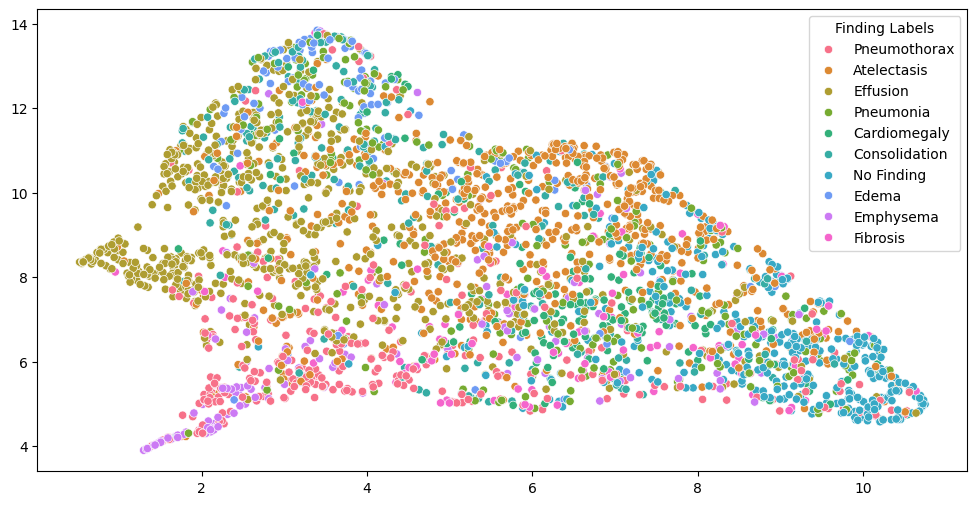

In [5]:
%%time

import umap.umap_ as umap
umap = umap.UMAP()

plt.figure(figsize=(12,6))
embedding = df_train[~df_train['Finding Labels'].str.contains('\|', regex=True)]
embed_2d = umap.fit_transform(embedding.drop(columns=embedding.columns[:14]))
sns.scatterplot(x=embed_2d[:,0], y=embed_2d[:,1], hue=df_train[~df_train['Finding Labels'].str.contains('\|', regex=True)]['Finding Labels'], palette=sns.color_palette("husl", n_colors=10), sizes=2)

plt.show()

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
kmeans.fit(embed_2d)
embedding['cluster'] = kmeans.labels_

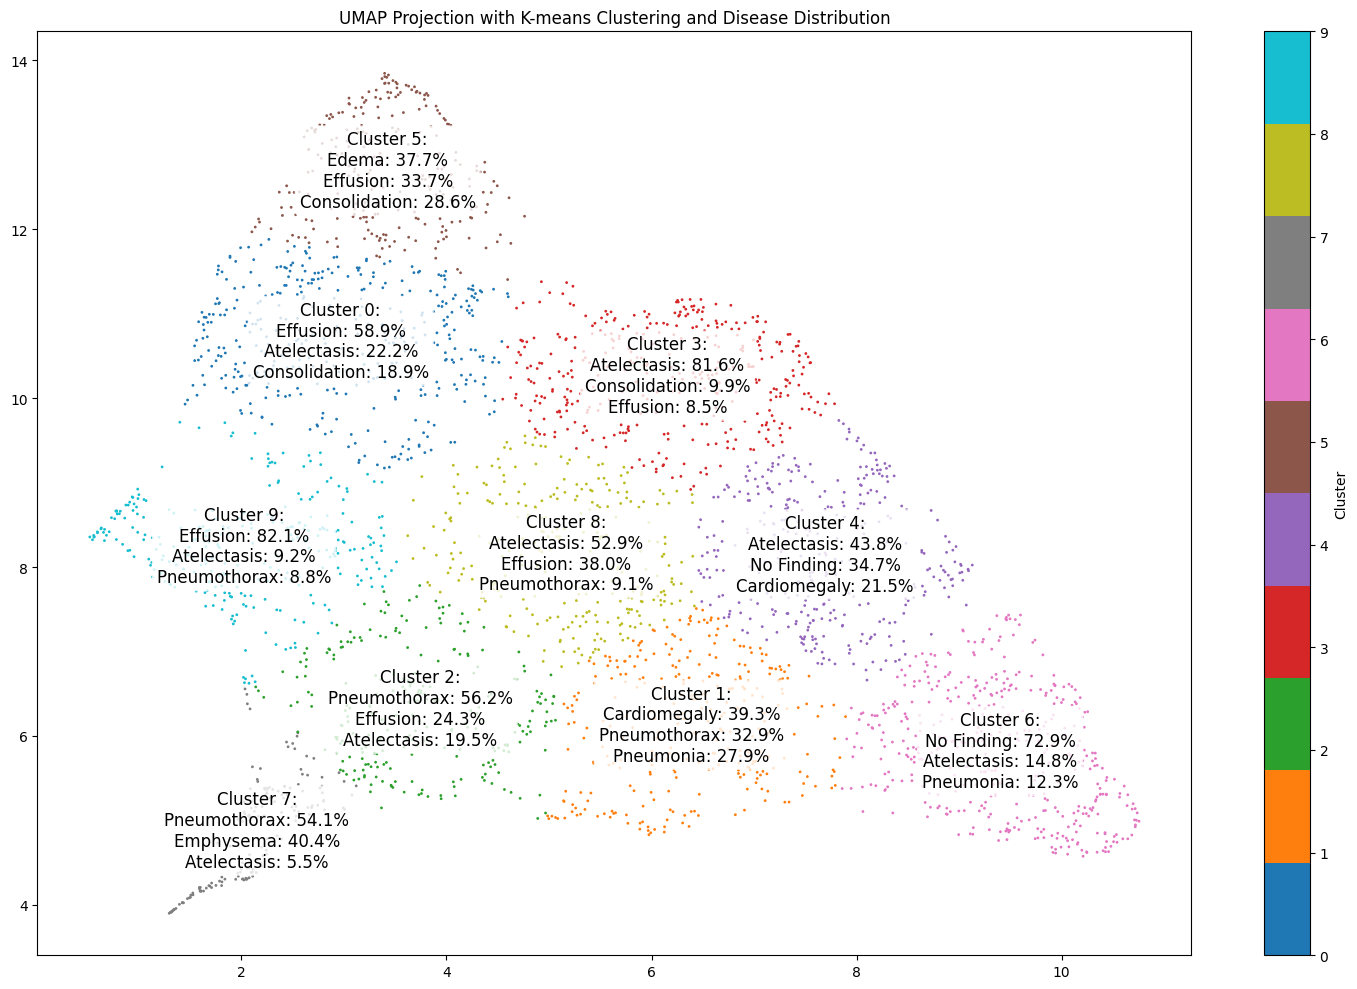

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter


# 각 클러스터의 질병 분포 찾기
cluster_diseases = {}
for cluster in range(10):
    cluster_labels = embedding[embedding['cluster'] == cluster]['Finding Labels']
    common_diseases = Counter(cluster_labels).most_common(3)  # 상위 3개 질병 선택
    cluster_diseases[cluster] = common_diseases

# 시각화
plt.figure(figsize=(15,10))
scatter = plt.scatter(embed_2d[:,0], embed_2d[:,1], s=1, c=embedding['cluster'], cmap='tab10')

# 클러스터 중심에 질병 분포 표시
centers = kmeans.cluster_centers_
for k in range(len(centers)):
    diseases = cluster_diseases[k]
    label = f"Cluster {k}:\n" + "\n".join([f"{d}: {c/sum([x[1] for x in diseases])*100:.1f}%" for d, c in diseases])
    plt.annotate(label, (centers[k,0], centers[k,1]),
                 xytext=(0, 0), textcoords="offset points",
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.8),
                 ha='center', va='center', fontsize=12)

plt.colorbar(scatter, label='Cluster')
plt.title('UMAP Projection with K-means Clustering and Disease Distribution')
plt.tight_layout()
plt.show()

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 1. 각 클러스터의 크기 확인
cluster_sizes = embedding['cluster'].value_counts().sort_index()
print("클러스터별 크기:")
print(cluster_sizes)

# 2. 클러스터별 질병 분포 분석
def get_top_diseases(cluster_data, n=5):
    return Counter(cluster_data['Finding Labels']).most_common(n)

cluster_diseases = {cluster: get_top_diseases(embedding[embedding['cluster'] == cluster])
                    for cluster in range(10)}

print("\n클러스터별 상위 5개 질병:")
for cluster, diseases in cluster_diseases.items():
    print(f"Cluster {cluster}:")
    for disease, count in diseases:
        print(f"  {disease}: {count}")
    print()

클러스터별 크기:
cluster
0    401
1    312
2    259
3    376
4    340
5    262
6    443
7    158
8    283
9    292
Name: count, dtype: int64

클러스터별 상위 5개 질병:
Cluster 0:
  Effusion: 196
  Atelectasis: 74
  Consolidation: 63
  Pneumonia: 31
  Edema: 18

Cluster 1:
  Cardiomegaly: 55
  Pneumothorax: 46
  Pneumonia: 39
  Fibrosis: 31
  No Finding: 29

Cluster 2:
  Pneumothorax: 104
  Effusion: 45
  Atelectasis: 36
  Emphysema: 21
  Fibrosis: 20

Cluster 3:
  Atelectasis: 231
  Consolidation: 28
  Effusion: 24
  Pneumonia: 23
  No Finding: 21

Cluster 4:
  Atelectasis: 106
  No Finding: 84
  Cardiomegaly: 52
  Pneumonia: 35
  Effusion: 20

Cluster 5:
  Edema: 66
  Effusion: 59
  Consolidation: 50
  Pneumonia: 44
  Atelectasis: 15

Cluster 6:
  No Finding: 237
  Atelectasis: 48
  Pneumonia: 40
  Pneumothorax: 35
  Fibrosis: 26

Cluster 7:
  Pneumothorax: 79
  Emphysema: 59
  Atelectasis: 8
  Pneumonia: 4
  Effusion: 4

Cluster 8:
  Atelectasis: 110
  Effusion: 79
  Pneumothorax: 19
  Consolidation:

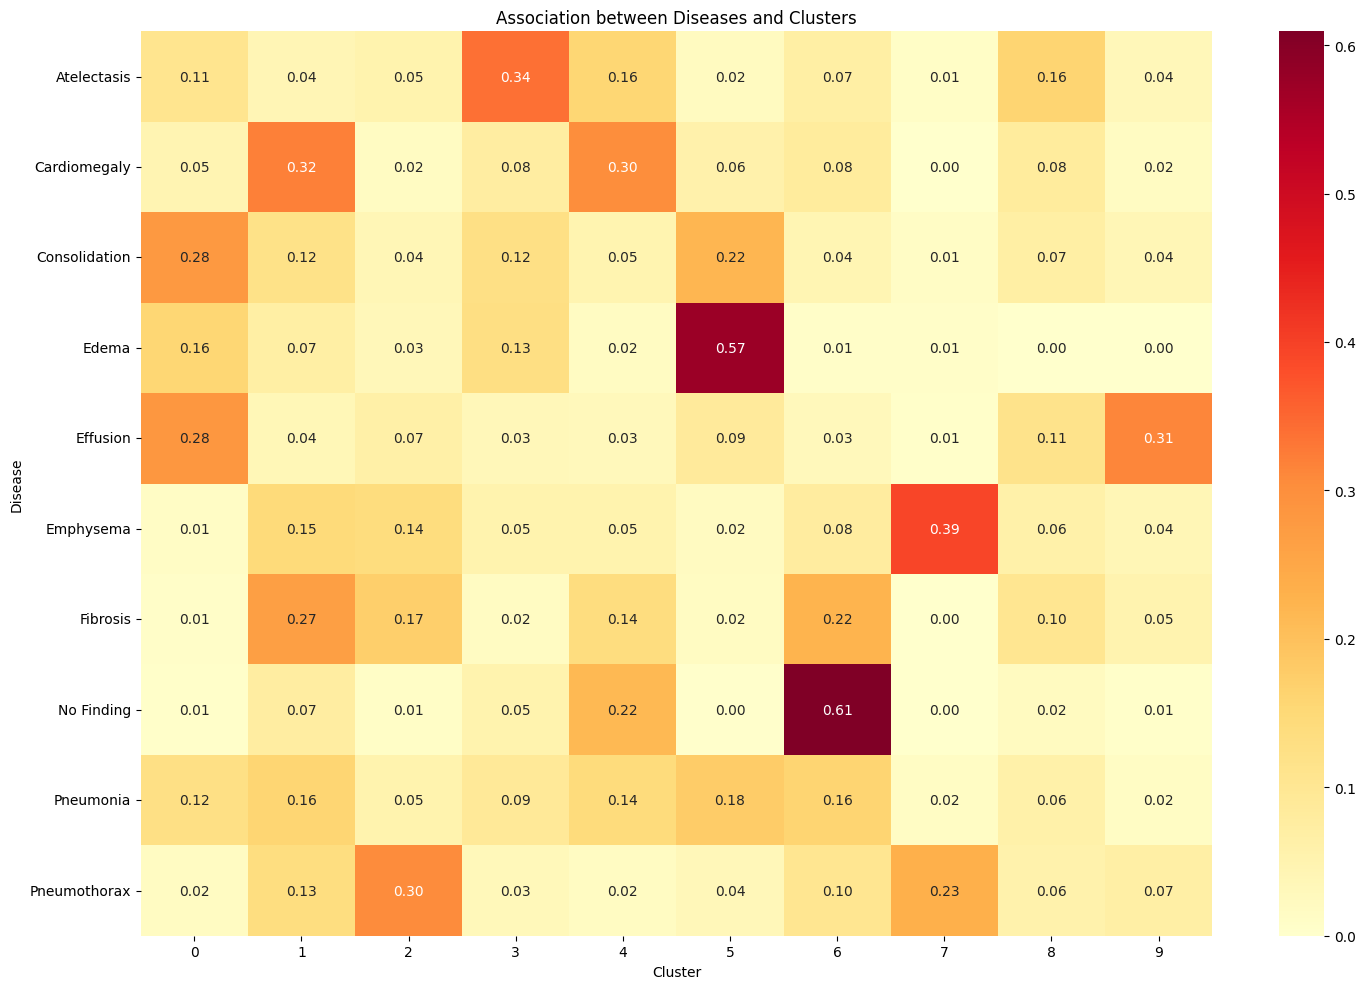

Most associated diseases for each cluster:
Cluster 0: Effusion (28.49%), Consolidation (27.88%), Edema (15.65%)
Cluster 1: Cardiomegaly (31.98%), Fibrosis (26.72%), Pneumonia (15.73%)
Cluster 2: Pneumothorax (30.50%), Fibrosis (17.24%), Emphysema (14.00%)
Cluster 3: Atelectasis (33.92%), Edema (13.04%), Consolidation (12.39%)
Cluster 4: Cardiomegaly (30.23%), No Finding (21.59%), Atelectasis (15.57%)
Cluster 5: Edema (57.39%), Consolidation (22.12%), Pneumonia (17.74%)
Cluster 6: No Finding (60.93%), Fibrosis (22.41%), Pneumonia (16.13%)
Cluster 7: Emphysema (39.33%), Pneumothorax (23.17%), Pneumonia (1.61%)
Cluster 8: Atelectasis (16.15%), Effusion (11.48%), Fibrosis (10.34%)
Cluster 9: Effusion (31.25%), Pneumothorax (6.74%), Fibrosis (5.17%)

Most associated clusters for each disease:
Atelectasis: 3 (33.92%), 8 (16.15%), 4 (15.57%)
Cardiomegaly: 1 (31.98%), 4 (30.23%), 6 (8.14%)
Consolidation: 0 (27.88%), 5 (22.12%), 3 (12.39%)
Edema: 5 (57.39%), 0 (15.65%), 3 (13.04%)
Effusion: 9 (

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

disease_cluster = pd.crosstab(embedding['Finding Labels'], embedding['cluster'])
disease_cluster_norm = disease_cluster.div(disease_cluster.sum(axis=1), axis=0)

# Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(disease_cluster_norm, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Association between Diseases and Clusters')
plt.xlabel('Cluster')
plt.ylabel('Disease')
plt.tight_layout()
plt.show()

# Function to get top n associations with percentages
def get_top_associations(series, n=3):
    sorted_series = series.sort_values(ascending=False)
    top_n = sorted_series.head(n)
    return ', '.join([f"{index} ({value:.2%})" for index, value in top_n.items()])

# Most associated diseases for each cluster
print("Most associated diseases for each cluster:")
for cluster in disease_cluster_norm.columns:
    print(f"Cluster {cluster}: {get_top_associations(disease_cluster_norm[cluster])}")

print("\nMost associated clusters for each disease:")
for disease in disease_cluster_norm.index:
    print(f"{disease}: {get_top_associations(disease_cluster_norm.loc[disease])}")